# Collaboration and Competition


In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

The environment considered solved when we reach average score of 0.5 over 100 episodes taking maximum score of the episode.


I have implemented policy based algorithm PPO based on [PPO paper](https://arxiv.org/abs/1707.06347) and inside PPO, I used [GAE (Generalized Advantage Estimation](https://arxiv.org/pdf/1506.02438.pdf).

In PPO algorithm a small batch of experiences interacting with the environment is collected, and based on that  decision-making policy is updated. Once the policy is updated with this batch, the experiences are thrown away and a newer batch is collected with the newly updated policy. This is the reason why it is an “on-policy learning” approach where the experience samples collected are only useful for updating the current policy once.

PPO algorithm makes sure that a new update of the policy is not cangingtoo much from the previous policy. It results in less variance in training however introduces some bias. PPO ensures smoother training and makes sure that agent does not go down an unrecoverable path of taking senseless actions.

### The Agent

I use Actor/Critic framework for policy model.

The Actor performs the task of learning what action to take under a particular observed state of the environment.
We send the action predicted by the Actor to our environment and observe what happens.
If something positive happens as a result of our action, then the environment sends back a positive response in the form of a reward. The reward is taken in by the Critic.
The Critic is learns to evaluate if Actor's action led to better state of our environment or not and provide the feedback to the Actor. Critic outputs a real number (state value function) of the action taken in the previous state. By comparing this rating obtained from the Critic, the Actor can compare its current policy with a new policy and decide what to do in order to improve, so it can to take better actions.


### Hyperparameters

I have tried different [settings of hyperparameters](https://medium.com/aureliantactics/ppo-hyperparameters-and-ranges-6fc2d29bccbe)

gamma=0.99  - is a constant known as discount factor, it is a measure of how far ahead in time the algorithm looks. To prioritise rewards in the distant future, we set the value closer to one. 

gae_lambda=0.95 - is parameter used when calculating the Generalized Advantage Estimate (GAE). This can be thought of as how much the agent relies on its current value estimate when calculating an updated value estimate. Low values correspond to relying more on the current value estimate (which can be high bias), and high values correspond to relying more on the actual rewards received in the environment (which can be high variance). The parameter provides a trade-off between the two, and the right value can lead to a more stable training process.

eps=0.2 - clipping parameter (eps), which corresponds to the acceptable threshold of divergence between the old and new policies during gradient descent updating. Setting this value small will result in more stable updates, but will also slow the training process.

tmax=1024 - model is updated after each 1024 simulator time steps.

batch_size=128 - is the number of experiences used for one iteration of a gradient descent update.

n_epoch=20 is the number of passes through the experience buffer during gradient descent. 

lr=1e-4 learning rate, optimal for [Adam Optimizer](https://medium.com/octavian-ai/which-optimizer-and-learning-rate-should-i-use-for-deep-learning-5acb418f9b2).



### Model Architectures

Actor model consists of following layers:
- Input Layer(8)
- Dense(512)
- Leaky ReLU
- Dense(256)
- Leaky ReLU
- Dense(2)
- tanh 

Critic model consists of following layers:

- Input Layer(8)
- Dense(512)
- Leaky ReLU
- Dense(256)
- Leaky ReLU
- Dense(1)

The structure of the Critic neural net is almost the same as the Actor. The only major difference is that the final layer of Critic outputs a real number. The activation used is tanh and not softmax since we do not need a probability distribution here like with the Actor.

The important step in the PPO algorithm is to run through this entire loop with the two models for a number of steps (PPO steps). While we are interacting with our environemt for certain number of steps and we arecollecting the states, actions, rewards, etc. that we will use for training.

The output of actor model is used by mean parameter of normal distribution. When agent plays in simulator, actor draws actions from distribution at random. When agent updates model based on actions from the model, actor returns likelihood of actions of distribution. Variance parameters of normal distribution are model parameters.

We interact with the environment for a fixed number of steps and collect experiences. These experiences are used to update the policies of our models after we have a large enough batch of such samples. 



Environments contain brains which are responsible for deciding the actions of their associated agents. We are going to check for the first brain available, and set it as the default brain we will be controlling from Python.

When training the environment, we set train_mode=True, so that the line for resetting the environment looks like the following:
env_info = env.reset(train_mode=True)[brain_name]


In [4]:
def get_env_info(env):
    # reset the environment
    brain_name = env.brain_names[0]
    brain = env.brains[brain_name]
    env_info = env.reset(train_mode=True)[brain_name]
    n_agent = len(env_info.agents)
    action_dim = brain.vector_action_space_size
    states = env_info.vector_observations
    state_dim = states.shape[1]

    return n_agent, state_dim, action_dim


def train():
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    
    scores_episode = []
    number_episode = []
    
    env = UnityEnvironment(file_name="Tennis.app")
    n_agent, state_dim, action_dim = get_env_info(env)
    model = GaussianActorCriticNetwork(state_dim, action_dim, hiddens=[512, 256])
    model = model.to(device)
    agent = PPOAgent(env, model, tmax=1024, n_epoch=20,
                     batch_size=128, eps=0.2, device=device)

    n_step = 2000
    n_episodes = 0
    for step in range(n_step):
        agent.step()
        scores = agent.scores_by_episode
        if n_episodes < len(scores):
            n_episodes = len(scores)
            print(f" episode #{n_episodes} : score = {scores[-1]:.2f}", end="")
            if 100 <= n_episodes:
                rewards_ma = np.mean(scores[-100:])
                scores_episode.append(rewards_ma)
                number_episode.append(n_episodes)
                print(f", mean score of last 100 episodes = {rewards_ma:.2f}")
                if .5 <= rewards_ma:
                    torch.save(model.state_dict(), "succesfulAgent.pth")
                    #with open('rewards.pickle', 'wb') as fp:
                     #   pickle.dump(scores, fp)
                    print("Environment solved")
                    break
            else:
                print()

        #sys.stdout.flush()
        

    print("Finished.")
    
    return scores_episode, number_episode

if __name__ == "__main__":
    scores, episodes = train()

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


 episode #72 : score = -0.00
 episode #138 : score = -0.00, mean score of last 100 episodes = -0.00
 episode #199 : score = -0.00, mean score of last 100 episodes = 0.00
 episode #260 : score = -0.00, mean score of last 100 episodes = 0.00
 episode #322 : score = -0.00, mean score of last 100 episodes = 0.00
 episode #377 : score = -0.00, mean score of last 100 episodes = 0.00
 episode #435 : score = -0.00, mean score of last 100 episodes = 0.00
 episode #490 : score = -0.00, mean score of last 100 episodes = 0.01
 episode #544 : score = -0.00, mean score of last 100 episodes = 0.01
 episode #584 : score = 0.10, mean score of last 100 episodes = 0.01
 episode #633 : score = 0.05, mean score of last 100 episodes = 0.02
 episode #687 : score = -0.00, mean score of last 100 episodes = 0.01
 episode #741 : score = 0.10, mean score of last 100 episodes = 0.01
 episode #784 : score = -0.00, mean score of last 100 episodes = 0.01
 episode #828 : score = 0.05, mean score of last 100 episodes =

 episode #2467 : score = 0.30, mean score of last 100 episodes = 0.43
 episode #2471 : score = 0.05, mean score of last 100 episodes = 0.42
 episode #2473 : score = 0.25, mean score of last 100 episodes = 0.45
 episode #2482 : score = 0.05, mean score of last 100 episodes = 0.45
 episode #2491 : score = 0.05, mean score of last 100 episodes = 0.44
 episode #2497 : score = 0.15, mean score of last 100 episodes = 0.44
 episode #2502 : score = 0.05, mean score of last 100 episodes = 0.46
 episode #2505 : score = 0.05, mean score of last 100 episodes = 0.47
 episode #2512 : score = 0.05, mean score of last 100 episodes = 0.49
 episode #2516 : score = 0.10, mean score of last 100 episodes = 0.50
 episode #2519 : score = 1.30, mean score of last 100 episodes = 0.52
Environment solved
Finished.


### Plot of Rewards

The environment was solved in 2519 episodes.

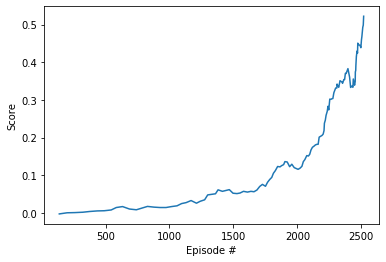

In [5]:
from __future__ import division
import matplotlib.pyplot as plt

%matplotlib inline
# plot the scores
x = np.array([episodes])
y = np.array([scores])
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(episodes, scores)
#plt.plot(np.arange(episodes), scores)
#plt.plot(np.arange(episodes),y)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### Ideas for Future Work

1. I plan on experementing with some hyper parameter changes within [recommended range](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Training-PPO.md)

- Experiment with normalization. Normalization is based on the running average and variance of the vector observation. Normalization can be helpful in cases with complex continuous control problems, but may be harmful with simpler discrete control problem

- Tuning epsilon. If it is small will result in more stable updates, but will also slow the training process.

- Try different learning rate. This should typically be decreased if training is unstable, and the reward does not consistently increase.

- Change number of epochs. The larger the batch_size, the larger it is acceptable to make this. Decreasing this will ensure more stable updates, at the cost of slower learning.

- Lambda - the right value can lead to a more stable training process.

2. I am planning to implement MA-DDPG  algorithm which is ready for multi-agent environement. 

